In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, RepeatVector, TimeDistributed
from unicodedata import normalize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical

from numpy import array
import pickle
#from keras.utils.vis_utils import plot_model


from nltk.corpus import stopwords
import string
import re

import matplotlib.pyplot as plt
%matplotlib inline

## Language Translator

In [2]:
import nltk

From `nltk` we can download translated sentences between different languages. You can see the example between **English and French** below but feel free to try different combination as well.

In [3]:
nltk.download('comtrans')

[nltk_data] Downloading package comtrans to /home/aj/nltk_data...
[nltk_data]   Package comtrans is already up-to-date!


True

In [4]:
from nltk.corpus import comtrans
print(comtrans.aligned_sents('alignment-en-fr.txt')[0])

<AlignedSent: 'Resumption of the se...' -> 'Reprise de la sessio...'>


In [5]:
len(comtrans.aligned_sents('alignment-en-fr.txt'))

33334

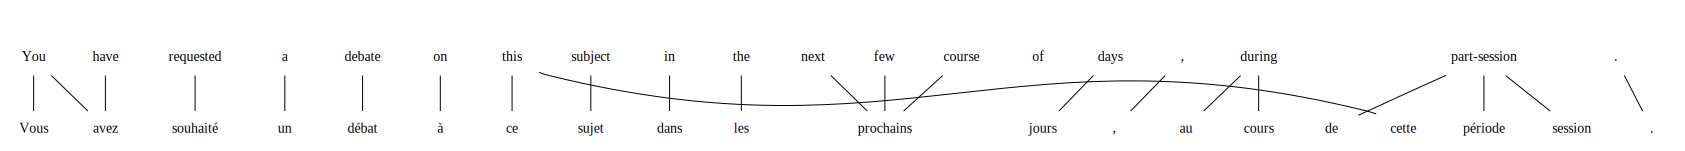

In [6]:
comtrans.aligned_sents('alignment-en-fr.txt')[2]

In [7]:
print(comtrans.aligned_sents('alignment-en-fr.txt')[2].words)
print(comtrans.aligned_sents('alignment-en-fr.txt')[2].mots)
print(comtrans.aligned_sents('alignment-en-fr.txt')[2].alignment)

['You', 'have', 'requested', 'a', 'debate', 'on', 'this', 'subject', 'in', 'the', 'course', 'of', 'the', 'next', 'few', 'days', ',', 'during', 'this', 'part-session', '.']
['Vous', 'avez', 'souhaité', 'un', 'débat', 'à', 'ce', 'sujet', 'dans', 'les', 'prochains', 'jours', ',', 'au', 'cours', 'de', 'cette', 'période', 'de', 'session', '.']
0-0 0-1 1-1 2-2 3-3 4-4 5-5 6-6 7-7 8-8 9-9 10-10 13-10 14-10 15-11 16-12 17-13 17-14 18-16 19-17 19-18 19-19 20-20


In [8]:
dataset = comtrans.aligned_sents('alignment-en-fr.txt')

In [14]:
def retrieve_corpora(corpora):
    print("Retrieving corpora: {}".format(corpora))
    als = comtrans.aligned_sents(corpora)
    eng_sen = [sent.words for sent in als]
    fre_sen = [sent.mots for sent in als]
    return [eng_sen, fre_sen]

In [16]:
dataset = retrieve_corpora('alignment-en-fr.txt')

Retrieving corpora: alignment-en-fr.txt


In [17]:
pickle.dump(dataset, open('dataset.txt', 'wb'))

In [18]:
dataset = pickle.load(open('dataset.txt', 'rb'))

In [22]:
text1 = dataset[0]

In [23]:
text2 = dataset[1]

In [24]:
print("DE:", text1[0])
print("EN:", text2[0])
print("# Corpora length (i.e. number of sentences)")
print(len(text2))

DE: ['Resumption', 'of', 'the', 'session']
EN: ['Reprise', 'de', 'la', 'session']
# Corpora length (i.e. number of sentences)
33334


In [22]:
def clean_sentence(sentence):
    regex_splitter = re.compile('[^%s]' % re.escape(string.printable))
    clean_words = [re.split(regex_splitter, word.lower()) for word in sentence]
    return [w for words in clean_words for w in words if words if w]

In [23]:
clean_sen_l1 = [clean_sentence(s) for s in text1]
clean_sen_l2 = [clean_sentence(s) for s in text2]
print("# Same sentence as before, but chunked and cleaned")
print("DE:", clean_sen_l1[0])
print("EN:", clean_sen_l2[0])

# Same sentence as before, but chunked and cleaned
DE: ['resumption', 'of', 'the', 'session']
EN: ['reprise', 'de', 'la', 'session']


In [24]:
def filter_sentence_length(sentences_l1, sentences_l2, min_len=0, max_len=20):
    filtered_sentences_l1 = []
    filtered_sentences_l2 = []
    for i in range(len(sentences_l1)):
        if min_len <= len(sentences_l1[i]) <= max_len and min_len <= len(sentences_l2[i]) <= max_len:
            filtered_sentences_l1.append(sentences_l1[i])
            filtered_sentences_l2.append(sentences_l2[i])
    return filtered_sentences_l1, filtered_sentences_l2

In [25]:
filt_clean_sen_l1, filt_clean_sen_l2 = filter_sentence_length(clean_sen_l1, 
          clean_sen_l2)
print("# Filtered Corpora length (i.e. number of sentences)")
print(len(filt_clean_sen_l1))
assert len(filt_clean_sen_l1) == len(filt_clean_sen_l2)

# Filtered Corpora length (i.e. number of sentences)
12861


In [26]:
clean_sen_l1[0]

['resumption', 'of', 'the', 'session']

In [22]:
re.escape(string.printable)

'0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"\\#\\$%\\&\'\\(\\)\\*\\+,\\-\\./:;<=>\\?@\\[\\\\\\]\\^_`\\{\\|\\}\\~\\ \\\t\\\n\\\r\\\x0b\\\x0c'

In [13]:
# max sentence length
def max_length(lines):
    return max(len(line.split()) for line in lines)

In [27]:
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [28]:
# prepare english tokenizer
eng_tokenizer = create_tokenizer(filt_clean_sen_l1)
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = 20 #max_length(filt_clean_sen_l1)
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))

# prepare french tokenizer
fre_tokenizer = create_tokenizer(filt_clean_sen_l2)
fre_vocab_size = len(fre_tokenizer.word_index) + 1
fre_length = 20 #max_length(filt_clean_sen_l2)
print('French Vocabulary Size: %d' % fre_vocab_size)
print('French Max Length: %d' % (fre_length))

English Vocabulary Size: 8783
English Max Length: 20
French Vocabulary Size: 10264
French Max Length: 20


In [29]:
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    X = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    X = pad_sequences(X, maxlen=length, padding='post')
    return X

In [30]:
# one hot encode target sequence
def encode_output(sequences, vocab_size):
    ylist = list()
    for sequence in sequences:
        encoded = to_categorical(sequence, num_classes=vocab_size)
        ylist.append(encoded)
    y = array(ylist)
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    return y

In [31]:
train = [filt_clean_sen_l1[9500:10000], filt_clean_sen_l2[9500:10000]]
test = [filt_clean_sen_l1[10000:10100], filt_clean_sen_l2[10000:10100]]

In [32]:
len(test[0])

100

In [33]:
from tensorflow.keras.utils import to_categorical

In [34]:
trainX = encode_sequences(fre_tokenizer, fre_length, filt_clean_sen_l1[:1000])
trainY = encode_sequences(eng_tokenizer, eng_length, filt_clean_sen_l2[:1000])
trainY = encode_output(trainY, eng_vocab_size)
# prepare validation data
testX = encode_sequences(fre_tokenizer, fre_length, filt_clean_sen_l1[1000:1200])
testY = encode_sequences(eng_tokenizer, eng_length, filt_clean_sen_l2[1000:1200])
testY = encode_output(testY, eng_vocab_size)

In [21]:
from numpy import array

In [35]:
# define NMT model
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
	model = Sequential()
	model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
	model.add(LSTM(n_units))
	model.add(RepeatVector(tar_timesteps))
	model.add(LSTM(n_units, return_sequences=True))
	model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
	return model

# define model
model = define_model(fre_vocab_size, eng_vocab_size, fre_length, eng_length, 256)
model.compile(optimizer='adam', loss='categorical_crossentropy')
# summarize defined model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 256)           2627584   
_________________________________________________________________
lstm (LSTM)                  (None, 256)               525312    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 20, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 256)           525312    
_________________________________________________________________
time_distributed (TimeDistri (None, 20, 8783)          2257231   
Total params: 5,935,439
Trainable params: 5,935,439
Non-trainable params: 0
_________________________________________________________________
None


NameError: name 'plot_model' is not defined

In [37]:
# fit model
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
model.fit(trainX, trainY, epochs=2, batch_size=128, validation_data=(testX, testY), callbacks=[checkpoint], verbose=2)

Epoch 1/2
8/8 - 205s - loss: 8.7444 - val_loss: 7.0939

Epoch 00001: val_loss improved from inf to 7.09389, saving model to model.h5


KeyboardInterrupt: 

In [29]:
def evaluate_model(model, tokenizer, sources, raw_dataset):
	actual, predicted = list(), list()
	for i, source in enumerate(sources):
		# translate encoded source text
		source = source.reshape((1, source.shape[0]))
		translation = predict_sequence(model, eng_tokenizer, source)
		raw_target, raw_src = raw_dataset[i]
		if i < 10:
			print('src=[%s], target=[%s], predicted=[%s]' % (raw_src, raw_target, translation))
		actual.append([raw_target.split()])
		predicted.append(translation.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [30]:
evaluate_model(model, eng_tokenizer, testX, test)

NameError: ignored

In [16]:
evaluate_model(model, eng_tokenizer, X, filt_clean_sen_l2)

NameError: name 'evaluate_model' is not defined

In [33]:
predict_sequence(model, eng_tokenizer, filt_clean_sen_l1)

NameError: ignored